In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("fo_data.db")
df = pd.read_csv("3mfanddo.csv")
df["exchange"] = "NSE"
df.to_sql("raw_fo_data", conn, if_exists="replace", index=False)
conn.close()
print("✅ Step 1 completed: Raw data loaded into SQLite")

/home/risk/jupyter-virtualenv-3.6/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


✅ Step 1 completed: Raw data loaded into SQLite


In [3]:
conn = sqlite3.connect("fo_data.db")
cur = conn.cursor()
cur.executescript("""
-- ===============================
DROP TABLE IF EXISTS trades;
DROP TABLE IF EXISTS expiries;
DROP TABLE IF EXISTS instruments;
DROP TABLE IF EXISTS exchanges;

-- ===============================

CREATE TABLE exchanges (
    exchange_id INTEGER PRIMARY KEY,
    exchange_name TEXT UNIQUE
);

INSERT INTO exchanges VALUES
(1, 'NSE'),
(2, 'BSE'),
(3, 'MCX');

-- ===============================
CREATE TABLE instruments (
    instrument_id INTEGER PRIMARY KEY AUTOINCREMENT,
    symbol TEXT,
    instrument_type TEXT,
    exchange_id INTEGER
);

INSERT INTO instruments (symbol, instrument_type, exchange_id)
SELECT DISTINCT
    SYMBOL,
    INSTRUMENT,
    1
FROM raw_fo_data;

-- ===============================

CREATE TABLE expiries (
    expiry_id INTEGER PRIMARY KEY AUTOINCREMENT,
    expiry_dt TEXT,
    strike_pr REAL,
    option_typ TEXT
);

INSERT INTO expiries (expiry_dt, strike_pr, option_typ)
SELECT DISTINCT
    EXPIRY_DT,
    STRIKE_PR,
    OPTION_TYP
FROM raw_fo_data;

-- ===============================

CREATE TABLE trades (
    trade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    instrument_id INTEGER,
    expiry_id INTEGER,
    trade_date TEXT,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    settle_pr REAL,
    volume INTEGER,
    open_int INTEGER,
    chg_in_oi INTEGER
);

INSERT INTO trades (
    instrument_id,
    expiry_id,
    trade_date,
    open,
    high,
    low,
    close,
    settle_pr,
    volume,
    open_int,
    chg_in_oi
)
SELECT
    i.instrument_id,
    e.expiry_id,
    substr(r.TIMESTAMP, 1, 10),
    r.OPEN,
    r.HIGH,
    r.LOW,
    r.CLOSE,
    r.SETTLE_PR,
    r.CONTRACTS,
    r.OPEN_INT,
    r.CHG_IN_OI
FROM raw_fo_data r
JOIN instruments i ON r.SYMBOL = i.symbol
JOIN expiries e
  ON r.EXPIRY_DT = e.expiry_dt
 AND r.STRIKE_PR = e.strike_pr
 AND r.OPTION_TYP = e.option_typ;
""")
conn.commit()
conn.close()
print("✅ Step 2 completed: Normalized tables created")

✅ Step 2 completed: Normalized tables created


In [4]:
conn = sqlite3.connect("fo_data.db")
cur = conn.cursor()
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_trades_trade_date ON trades(trade_date);
CREATE INDEX IF NOT EXISTS idx_trades_instrument ON trades(instrument_id);
CREATE INDEX IF NOT EXISTS idx_trades_expiry ON trades(expiry_id);
CREATE INDEX IF NOT EXISTS idx_trades_open_int ON trades(open_int);
CREATE INDEX IF NOT EXISTS idx_instruments_symbol ON instruments(symbol);
""")
conn.commit()
conn.close()
print("✅ Step 3 completed: Indexes created")

✅ Step 3 completed: Indexes created


In [ ]:
Top 10 Symbols by Open Interest Change

In [5]:
conn = sqlite3.connect("fo_data.db")
query_oi = """
SELECT
    i.symbol,
    MAX(t.open_int) - MIN(t.open_int) AS oi_change
FROM trades t
JOIN instruments i ON t.instrument_id = i.instrument_id
GROUP BY i.symbol
ORDER BY oi_change DESC
LIMIT 10;
"""
df_oi = pd.read_sql(query_oi, conn)
conn.close()
print(df_oi)

       symbol  oi_change
0        IDEA  632380000
1  IDFCFIRSTB  219360000
2     YESBANK  205631800
3    GMRINFRA  151335000
4        SBIN  124359000
5         ITC  113371200
6  ADANIPOWER  111320000
7      DISHTV  106442000
8         PNB  105567000
9        SAIL  103536000


In [ ]:
7-Day Rolling Volatility

In [6]:
conn = sqlite3.connect("fo_data.db")
df = pd.read_sql("""
SELECT
    trade_date,
    AVG(close) AS avg_close
FROM trades
GROUP BY trade_date
ORDER BY trade_date;
""", conn)
conn.close()

In [7]:
df["trade_date"] = df["trade_date"].str.replace(
    r"-(\d{3})$", r"-\g<1>9", regex=True
)
df["trade_date"] = pd.to_datetime(
    df["trade_date"], format="%d-%b-%Y", errors="coerce"
)
df = df.sort_values("trade_date")
df["volatility_7d"] = df["avg_close"].rolling(7).std()
df_vol = df.dropna(subset=["volatility_7d"])
print(df_vol[["trade_date", "volatility_7d"]].head(10))

   trade_date  volatility_7d
20 2019-08-09       1.629130
28 2019-08-13       2.113370
31 2019-08-14       2.634674
36 2019-08-16       2.856162
43 2019-08-19       2.665181
45 2019-08-20       2.330411
47 2019-08-21       1.917508
48 2019-08-22       1.862781
50 2019-08-23       1.479566
57 2019-08-26       1.442233


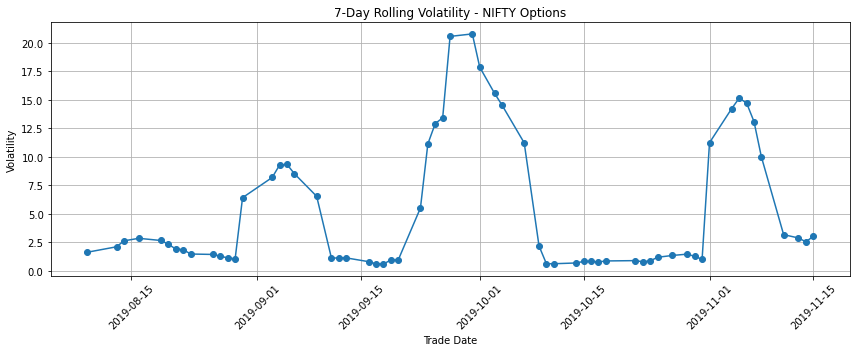

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(df_vol["trade_date"], df_vol["volatility_7d"], marker='o')
plt.title("7-Day Rolling Volatility - NIFTY Options")
plt.xlabel("Trade Date")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Put–Call Ratio (PCR)

In [8]:
conn = sqlite3.connect("fo_data.db")
df_pcr = pd.read_sql("""
SELECT
    t.trade_date,
    SUM(CASE WHEN e.option_typ = 'CE' THEN t.volume ELSE 0 END) AS call_vol,
    SUM(CASE WHEN e.option_typ = 'PE' THEN t.volume ELSE 0 END) AS put_vol
FROM trades t
JOIN expiries e ON t.expiry_id = e.expiry_id
GROUP BY t.trade_date
ORDER BY t.trade_date;
""", conn)
conn.close()
df_pcr["trade_date"] = df_pcr["trade_date"].str.replace(
    r"-(\d{3})$", r"-\g<1>9", regex=True
)
df_pcr["trade_date"] = pd.to_datetime(
    df_pcr["trade_date"], format="%d-%b-%Y", errors="coerce"
)
df_pcr["put_call_ratio"] = (
    df_pcr["put_vol"] /
    df_pcr["call_vol"].replace(0, pd.NA)
)
print(df_pcr.head())

  trade_date  call_vol   put_vol  put_call_ratio
0 2019-08-01  49498924  36148536        0.730289
1 2019-11-01   8340084   7479836        0.896854
2 2019-10-01  26311678  25183252        0.957113
3 2019-08-02  17579202  13323136        0.757892
4 2019-10-03  50428568  35178330        0.697587


In [ ]:
Option Chain Summary

In [9]:
conn = sqlite3.connect("fo_data.db")
df_chain = pd.read_sql("""
SELECT
    e.expiry_dt,
    e.strike_pr,
    e.option_typ,
    SUM(t.volume) AS total_volume,
    SUM(t.open_int) AS total_open_int
FROM trades t
JOIN expiries e ON t.expiry_id = e.expiry_id
GROUP BY e.expiry_dt, e.strike_pr, e.option_typ
ORDER BY e.expiry_dt, e.strike_pr;
""", conn)
conn.close()
print(df_chain.head())

     expiry_dt  strike_pr option_typ  total_volume  total_open_int
0  01-Aug-2019     9600.0         CE             0               0
1  01-Aug-2019     9600.0         PE            20            1500
2  01-Aug-2019     9650.0         CE             0               0
3  01-Aug-2019     9650.0         PE             0               0
4  01-Aug-2019     9700.0         CE             0               0


In [ ]:
Most Active Symbols

In [10]:
conn = sqlite3.connect("fo_data.db")
df_active = pd.read_sql("""
SELECT
    i.symbol,
    SUM(t.volume) AS total_volume
FROM trades t
JOIN instruments i ON t.instrument_id = i.instrument_id
WHERE t.trade_date >= DATE('now', '-30 day')
GROUP BY i.symbol
ORDER BY total_volume DESC
LIMIT 10;
""", conn)
conn.close()
print(df_active)

       symbol  total_volume
0   BANKNIFTY     622609744
1       NIFTY     288783778
2     YESBANK       8230634
3    RELIANCE       6412728
4        SBIN       5620242
5      MARUTI       4402992
6   ICICIBANK       3939276
7    HDFCBANK       3780232
8  IBULHSGFIN       3451196
9  TATAMOTORS       2923634
